In [13]:
import glob
# This file should run basically insta fast. Bad coding for sure 
# There is a place where i sometimes comment out lin/rbf/sigmoid stuff
# Dont do that, it really helps for some subjects. 
# Anything. Leave only linear. For fast testing of best features
# But dont do that either. 
import os
saveFolderName = "peak"
genSavePath = f"{os.getcwd()}/{saveFolderName}/SavedResults/"
day = "22" # Which month and days result you want to visualize in table
month = 11

repetitionValue =  87
repetitionName =  "peak2"#  "udrli1feattestanglnoBC"  # "udrliplotnoAda3"  #  "udrlBC4CVTest" # 
#  "udrliplotnoAda3hyperparams" 
repetitionString = f"{repetitionValue}{repetitionName}"
curSavePath = f"{genSavePath}{day}-{month}-{repetitionString}/"
savedResults = glob.glob(curSavePath + "savedBest*")

saveTop = True
if saveTop:
    saveTopName = "top3udv.npy"
else:
    saveTopName = None
topAmount = 20
skipSubjects = []
onlySignificant = True
minAcc = 0.0
print(len(savedResults))
print(len(savedResults)/9)


60
6.666666666666667


In [14]:
import pandas as pd
from array import ArrayType
from requests import delete
import numpy as np


nameDict = dict()
nrOfNames = 0
kernelDict = dict()
nrOfKernel = 0

currSeed = 0
currSubj = 0
combinationList = []

testInfoPerSubject = [None] * 10

results = []
for path in savedResults:
    results.append(np.load(path, allow_pickle=True))

subjectAmount = 10
    
for subject in results:
    currSubj = subject[1]
    testInfoPerSubject[currSubj] = subject[0]
soloFeatures = []
featCombos = []
kernels = testInfoPerSubject[1][2][0]
regValues = testInfoPerSubject[1][2][1]
paradigmName = testInfoPerSubject[1][3]
for subinfo in testInfoPerSubject[1:]:
    if subinfo is None:
        continue
    subSoloFeatures = subinfo[0]
    subfeatCombos = subinfo[1]
    if len(soloFeatures) < len(subSoloFeatures):
        soloFeatures = subSoloFeatures
    if len(featCombos) < len(subfeatCombos):
        featCombos = subfeatCombos
    #print(subinfo)
allCombinations = []
comboNumber = 0
combinationDict = dict()
for featCombo in featCombos:
    for kernel in kernels:
        for regValue in regValues:
            allCombinations.append([featCombo, kernel, regValue, comboNumber])
            combinationDict[f"{featCombo},{kernel},{regValue}"] = comboNumber
            comboNumber = comboNumber + 1
#print(combinationDict)
nrOfCombination = len(allCombinations)
combinationResult = np.zeros([subjectAmount, len(allCombinations), 2])
combinationAmounts = np.zeros([subjectAmount, len(allCombinations)])

nrOfSeedsPerSubject = np.zeros(subjectAmount)
seedCounted = np.zeros([subjectAmount, len(allCombinations), 20])
currSeed = -1
for s, subject in enumerate(results):
    currSubj = 0
    
    subjectBestArray = np.empty([len(subject)], dtype=object)

    
    currSubj = subject[1]
    # print(currSubj)
    # if currSubj == 1:
    #     currSeed = currSeed + 1 
    testInfoPerSubject[currSubj] = subject[0]
    if currSubj in skipSubjects:
        continue
    nrOfSeedsPerSubject[currSubj] += 1

    for aResults in subject[2]:
        for aResults2 in aResults:
            # If the np array comes from svm results
            if len(aResults2) < 10:
                
                aName = aResults2[0]
                ares = aResults2[1]
                akernel = aResults2[2]
 
                aC = aResults2[3]
               
                combinationResult[currSubj, combinationDict[f"{aName},{akernel},{aC}"]] = [int(combinationDict[f"{aName},{akernel},{aC}"]), 
                                                                                           combinationResult[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][1] + ares]
                # print(combinationDict[f"{aName},{akernel},{aC}"])

for subNr, subj in enumerate(combinationResult[1:], 1):
    combinationResult[subNr,:, 1] = combinationResult[subNr,:, 1] / nrOfSeedsPerSubject[subNr]
    if "adaBoost" in kernels or "MLP" in kernels:
        combinationResult[subNr,:, 1] = combinationResult[subNr,:, 1] / 2

combinationResult[combinationResult[:,:,1] > 1.001] = combinationResult[combinationResult[:,:,1] > 1.001] / 2
headers = np.arange(nrOfCombination)
subjectResultArray = np.empty([10, nrOfCombination], dtype=object)
subjectNrList = []

comboAverage = np.zeros([1, nrOfCombination])
comboTotal = np.zeros([1, nrOfCombination])
nrOfSubjects = np.zeros(nrOfCombination)

topTen = []
topThreeAllSubjects = []
topPerFeature = np.zeros([10, len(featCombos)])
allCombinations = np.array(allCombinations)
lowestTopRes = [0, 0]
for subNr, cResult in enumerate(combinationResult):
    topThreeThisSubject = []
    resArray = np.zeros([nrOfCombination])
    if len(cResult) != 0:
        for res in cResult:
            # print(res[0])
            cmbNr = int(res[0])
            # print(cmbNr)
            #print(cmbNr)
            if onlySignificant == True:
                if res[1] < minAcc:
                    continue
            comboAverage[0, cmbNr] = comboAverage[0, cmbNr] + res[1]
            comboTotal[0, cmbNr] = comboTotal[0, cmbNr] + res[1]
            nrOfSubjects[cmbNr] += 1
            subjectResultArray[subNr, cmbNr] = res[1]
            comboName = allCombinations[cmbNr][0]
            
            nameIndex = [i for i, elem in enumerate(featCombos) if comboName == elem][0]
            # print(comboName)
            #print(nameIndex)
            #print(featCombos[nameIndex])
   
            if res[1] > topPerFeature[subNr, nameIndex]:
                topPerFeature[subNr, nameIndex] = res[1]

            if len(topTen) < 10 or topTen[0][0] < res[1]:

                if len(topTen) == 10:
                    topTen.reverse()
                    topTen.pop()

                dataF = allCombinations[cmbNr][0]
                kernel =  allCombinations[cmbNr][1]
                cVal =  allCombinations[cmbNr][2]
                topTen.append([res[1], subNr, dataF, kernel, cVal])
                topTen.sort()
            
            if len(topThreeThisSubject) < 2 or topThreeThisSubject[0][0] < res[1]:

                if len(topThreeThisSubject) == 2:
                    topThreeThisSubject.reverse()
                    topThreeThisSubject.pop()
                dataF = allCombinations[cmbNr][0]
                kernel =  allCombinations[cmbNr][1]
                cVal =  allCombinations[cmbNr][2]
                topThreeThisSubject.append([res[1], subNr, dataF, kernel, cVal])
                topThreeThisSubject.sort()
    if len(topThreeThisSubject)>0:
        topThreeAllSubjects.append(topThreeThisSubject)
        
        
        
# Print the table!
comboAverage = comboAverage / nrOfSubjects
pd.set_option("display.max_columns", None)

# For loop through zip of headers and columns,
# If column has all values == None, Remove column and header.
subjectResultArray = np.array(subjectResultArray)
emptyCols = []
atleastOneEmpty = False
for hcol, in zip(headers):
    if all(subjectResultArray[:,hcol] == None):
        atleastOneEmpty = True
        emptyCols.append(hcol)
if atleastOneEmpty: 
    subjectResultArray = np.delete(subjectResultArray, np.array(emptyCols),1)
    headers = np.delete(headers, np.array(emptyCols),0)
    comboAverage = np.delete(comboAverage, np.array(emptyCols),1)
    comboTotal = np.delete(comboTotal, np.array(emptyCols),1)
    nrOfSubjects = np.delete(nrOfSubjects, np.array(emptyCols),0)


table = pd.DataFrame(subjectResultArray, columns=headers)
display(table)




,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758
0,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,No

In [15]:
pd.set_option("display.max_columns", None)
print()
nameDictNrs = np.ones([1, len(nameDict)])
nameDictNrs[0,:] = np.arange(len(nameDict)) * 3
table = pd.DataFrame(topPerFeature, columns=featCombos)
display(table)


,fftData,hilbertData,fftData_CV,hilbertData_CV,gausData,fftData_BC,hilbertData_BC,fftData_BC_CV,hilbertData_BC_CV,gausData_CV,gausData_CV_BC,gausData_BC,gausData_BC_CV,fftData_BC_ifft,fftData_BC_ifft_CV,stftData,stftData_BC,stftData_CV,stftData_BC_CV,fftData_CV_BC,hilbertData_CV_BC,stftData_CV_BC,hilbertData_&_fftData,fftData_CV_&_fftData,hilbertData_CV_&_fftData,gausData_&_fftData,fftData_BC_&_fftData,hilbertData_BC_&_fftData,fftData_BC_CV_&_fftData,hilbertData_BC_CV_&_fftData,gausData_CV_&_fftData,gausData_CV_BC_&_fftData,gausData_BC_&_fftData,gausData_BC_CV_&_fftData,fftData_BC_ifft_&_fftData,fftData_BC_ifft_CV_&_fftData,stftData_&_fftData,stftData_BC_&_fftData,stftData_CV_&_fftData,stftData_BC_CV_&_fftData,fftData_CV_BC_&_fftData,hilbertData_CV_BC_&_fftData,stftData_CV_BC_&_fftData,fftData_CV_&_hilbertData,hilbertData_CV_&_hilbertData,gausData_&_hilbertData,fftData_BC_&_hilbertData,hilbertData_BC_&_hilbertData,fftData_BC_CV_&_hilbertData,hilbertData_BC_CV_&_hilbertData,gausData_CV_&_hilbertData,gausData_CV_BC_&_hilbertData,gausData_BC_&_hilbertData,gausData_BC_CV_&_hilbertData,fftData_BC_ifft_&_hilbertData,fftData_BC_ifft_CV_&_hilbertData,stftData_&_hilbertData,stftData_BC_&_hilbertData,stftData_CV_&_hilbertData,stftData_BC_CV_&_hilbertData,fftData_CV_BC_&_hilbertData,hilbertData_CV_BC_&_hilbertData,stftData_CV_BC_&_hilbertData,hilbertData_CV_&_fftData_CV,gausData_&_fftData_CV,fftData_BC_&_fftData_CV,hilbertData_BC_&_fftData_CV,fftData_BC_CV_&_fftData_CV,hilbertData_BC_CV_&_fftData_CV,gausData_CV_&_fftData_CV,gausData_CV_BC_&_fftData_CV,gausData_BC_&_fftData_CV,gausData_BC_CV_&_fftData_CV,fftData_BC_ifft_&_fftData_CV,fftData_BC_ifft_CV_&_fftData_CV,stftData_&_fftData_CV,stftData_BC_&_fftData_CV,stftData_CV_&_fftData_CV,stftData_BC_CV_&_fftData_CV,fftData_CV_BC_&_fftData_CV,hilbertData_CV_BC_&_fftData_CV,stftData_CV_BC_&_fftData_CV,gausData_&_hilbertData_CV,fftData_BC_&_hilbertData_CV,hilbertData_BC_&_hilbertData_CV,fftData_BC_CV_&_hilbertData_CV,hilbertData_BC_CV_&_hilbertData_CV,gausData_CV_&_hilbertData_CV,gausData_CV_BC_&_hilbertData_CV,gausData_BC_&_hilbertData_CV,gausData_BC_CV_&_hilbertData_CV,fftData_BC_ifft_&_hilbertData_CV,fftData_BC_ifft_CV_&_hilbertData_CV,stftData_&_hilbertData_CV,stftData_BC_&_hilbertData_CV,stftData_CV_&_hilbertData_CV,stftData_BC_CV_&_hilbertData_CV,fftData_CV_BC_&_hilbertData_CV,hilbertData_CV_BC_&_hilbertData_CV,stftData_CV_BC_&_hilbertData_CV,fftData_BC_&_gausData,hilbertData_BC_&_gausData,fftData_BC_CV_&_gausData,hilbertData_BC_CV_&_gausData,gausData_CV_&_gausData,gausData_CV_BC_&_gausData,gausData_BC_&_gausData,gausData_BC_CV_&_gausData,fftData_BC_ifft_&_gausData,fftData_BC_ifft_CV_&_gausData,stftData_&_gausData,stftData_BC_&_gausData,stftData_CV_&_gausData,stftData_BC_CV_&_gausData,fftData_CV_BC_&_gausData,hilbertData_CV_BC_&_gausData,stftData_CV_BC_&_gausData,hilbertData_BC_&_fftData_BC,fftData_BC_CV_&_fftData_BC,hilbertData_BC_CV_&_fftData_BC,gausData_CV_&_fftData_BC,gausData_CV_BC_&_fftData_BC,gausData_BC_&_fftData_BC,gausData_BC_CV_&_fftData_BC,fftData_BC_ifft_&_fftData_BC,fftData_BC_ifft_CV_&_fftData_BC,stftData_&_fftData_BC,stftData_BC_&_fftData_BC,stftData_CV_&_fftData_BC,stftData_BC_CV_&_fftData_BC,fftData_CV_BC_&_fftData_BC,hilbertData_CV_BC_&_fftData_BC,stftData_CV_BC_&_fftData_BC,fftData_BC_CV_&_hilbertData_BC,hilbertData_BC_CV_&_hilbertData_BC,gausData_CV_&_hilbertData_BC,gausData_CV_BC_&_hilbertData_BC,gausData_BC_&_hilbertData_BC,gausData_BC_CV_&_hilbertData_BC,fftData_BC_ifft_&_hilbertData_BC,fftData_BC_ifft_CV_&_hilbertData_BC,stftData_&_hilbertData_BC,stftData_BC_&_hilbertData_BC,stftData_CV_&_hilbertData_BC,stftData_BC_CV_&_hilbertData_BC,fftData_CV_BC_&_hilbertData_BC,hilbertData_CV_BC_&_hilbertData_BC,stftData_CV_BC_&_hilbertData_BC,hilbertData_BC_CV_&_fftData_BC_CV,gausData_CV_&_fftData_BC_CV,gausData_CV_BC_&_fftData_BC_CV,gausData_BC_&_fftData_BC_CV,gausData_BC_CV_&_fftData_BC_CV,fftData_BC_ifft_&_fftData_BC_CV,fftData_BC_ifft_CV_&_fftData_BC_CV,stftData_&_fftData

(253,)




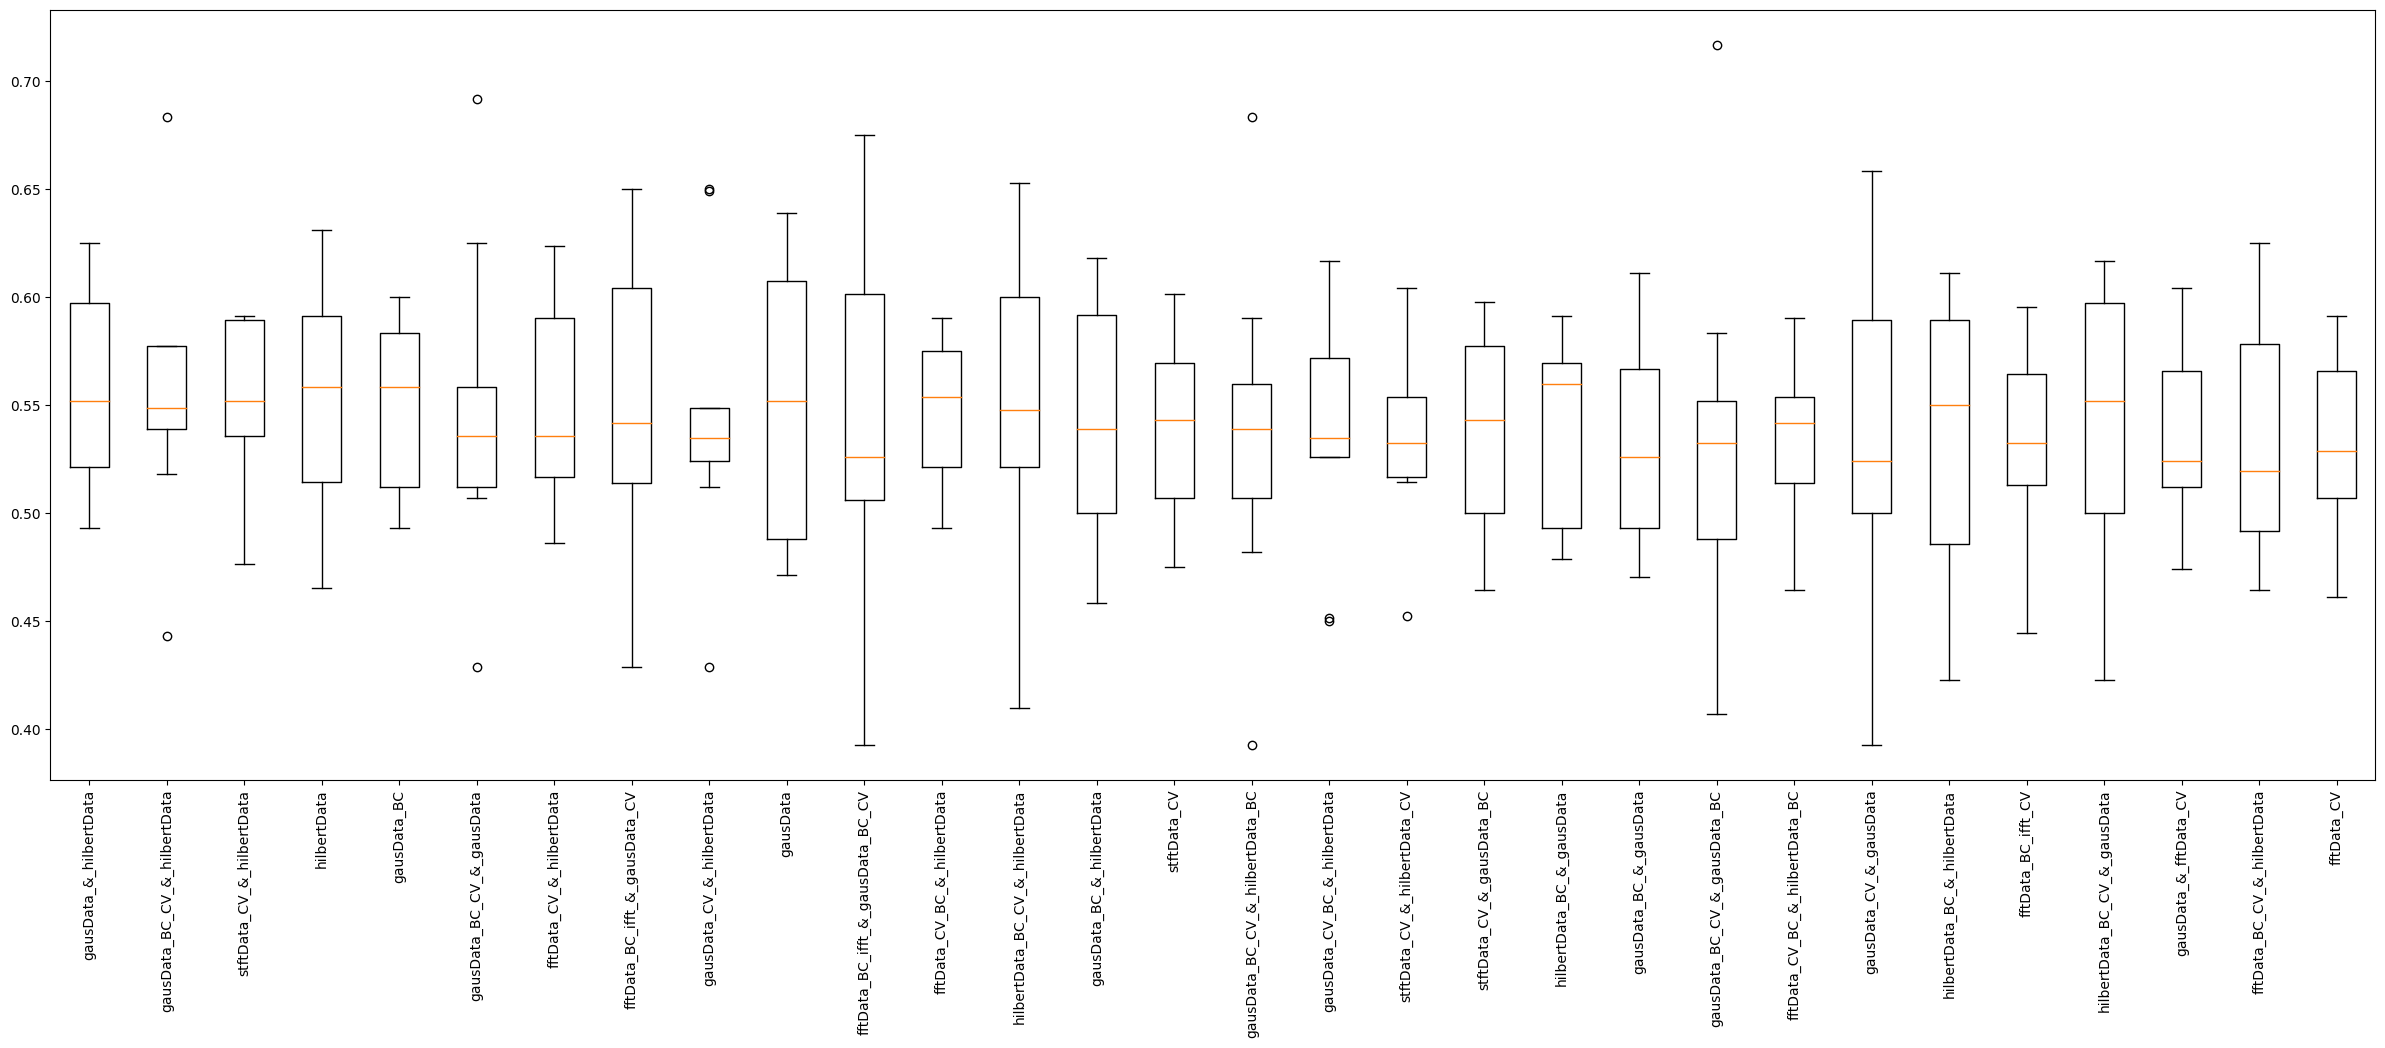

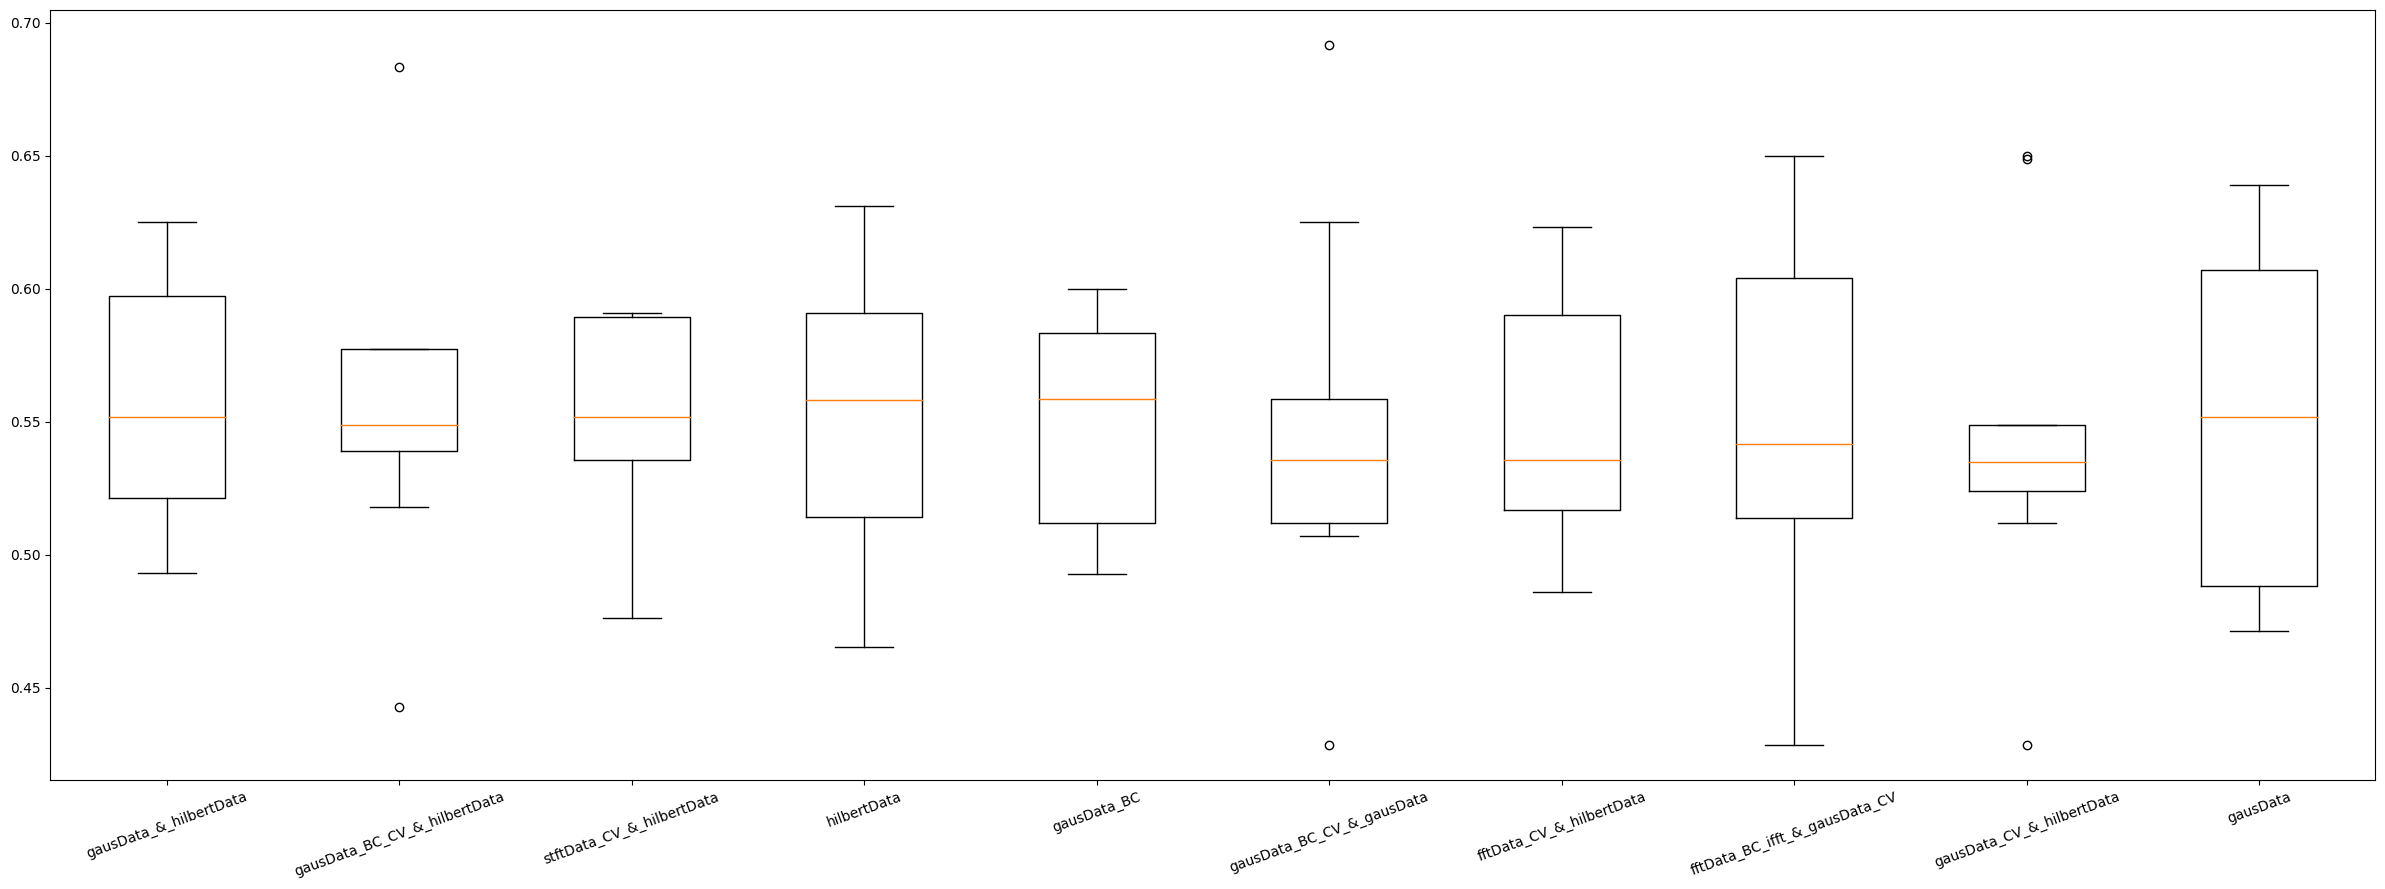

In [16]:
import matplotlib.pyplot as plt
meanTop = np.mean(topPerFeature[1:], axis=0)
indices = np.argsort(meanTop, axis=0)[::-1]

print(indices.shape)
featCombos = np.array(featCombos)

if len(featCombos) < 30:
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:30])
    plt.xticks(np.arange(len(featCombos[indices][:30]))+1,featCombos[indices][:30],rotation=45)
    print("")
else: 
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:30])
    plt.xticks(np.arange(30)+1,featCombos[indices][:30],rotation=90)
    print("")
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:10])
    plt.xticks(np.arange(10)+1,featCombos[indices][:10],rotation=20)
    print("")
    


In [17]:
print("Top ten highest accuracies")

topTen.reverse()
for top in topTen:
    print(
            f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
        )


Top ten highest accuracies
Accuracy 0.73 : subject 8, feature:gausData_BC_CV_&_fftData, kernellinear, C:2.5
Accuracy 0.73 : subject 8, feature:gausData_BC_CV_&_fftData_BC, kernellinear, C:2.5
Accuracy 0.73 : subject 8, feature:stftData_CV_BC_&_gausData_BC_CV, kernellinear, C:2.5
Accuracy 0.73 : subject 8, feature:hilbertData_CV_BC_&_gausData_BC_CV, kernellinear, C:2.5
Accuracy 0.73 : subject 8, feature:gausData_BC_CV_&_fftData, kernelsigmoid, C:2.5
Accuracy 0.72 : subject 8, feature:gausData_&_fftData, kernelrbf, C:2.5
Accuracy 0.72 : subject 8, feature:gausData_BC_CV_&_gausData_BC, kernellinear, C:2.5
Accuracy 0.72 : subject 8, feature:gausData_BC_&_fftData, kernellinear, C:2.5
Accuracy 0.71 : subject 8, feature:gausData_BC_CV_&_gausData_CV, kernelsigmoid, C:2.5
Accuracy 0.71 : subject 8, feature:gausData_BC_CV, kernellinear, C:2.5


In [18]:
print("Top ten highest accuracies")
for subTop in topThreeAllSubjects:
    subTop.reverse()

Top ten highest accuracies


In [19]:
topThreeAllSubjects.sort(reverse=True)
arrayOfTopFeatureNames = []
for subTop in topThreeAllSubjects[:-1]:
    print("")
    for top in subTop[:1]:
        arrayOfTopFeatureNames.append(top[2])
        print(
                f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
            )

arrayOfTopFeatureNames = np.array(arrayOfTopFeatureNames, dtype=object)
newArrayOfTopFeatureNames = []
for topNames in arrayOfTopFeatureNames:
    splitArray = []
    if "_&_" in topNames:
        splitArray = np.array(topNames.split("_&_"), dtype=object)
    else: 
        splitArray = [topNames]

    skip = False  
    if len(splitArray) < 2:
        continue
    newArrayOfTopFeatureNames.append(splitArray)
    
print(newArrayOfTopFeatureNames)
newArrayOfTopFeatureNames = np.array(newArrayOfTopFeatureNames, dtype=object) 
if saveTopName is not None:
    np.save(f"topFeatures/{saveTopName}", newArrayOfTopFeatureNames)
    print("TopFeatureNameArraySaved")
    print(newArrayOfTopFeatureNames)



Accuracy 0.73 : subject 8, feature:gausData_BC_CV_&_fftData, kernellinear, C:2.5

Accuracy 0.66 : subject 3, feature:fftData_CV_BC_&_fftData_BC_ifft, kernelsigmoid, C:2.5

Accuracy 0.66 : subject 2, feature:stftData_CV_&_gausData_CV, kernellinear, C:2.5

Accuracy 0.65 : subject 9, feature:hilbertData_BC_CV_&_hilbertData, kernelrbf, C:2.5

Accuracy 0.63 : subject 4, feature:hilbertData, kernellinear, C:2.5

Accuracy 0.62 : subject 7, feature:gausData_BC_CV_&_gausData, kernelsigmoid, C:2.5

Accuracy 0.62 : subject 5, feature:fftData_BC_ifft_&_gausData_CV, kernelsigmoid, C:2.5

Accuracy 0.62 : subject 6, feature:gausData_BC_CV_&_hilbertData_BC_CV, kernellinear, C:2.5

Accuracy 0.59 : subject 1, feature:stftData_&_fftData_BC_ifft_CV, kernelsigmoid, C:2.5
[array(['gausData_BC_CV', 'fftData'], dtype=object), array(['fftData_CV_BC', 'fftData_BC_ifft'], dtype=object), array(['stftData_CV', 'gausData_CV'], dtype=object), array(['hilbertData_BC_CV', 'hilbertData'], dtype=object), array(['gausDa

In [20]:
subjAv = np.zeros(subjectResultArray.shape[0])
for s, subj in enumerate(subjectResultArray):
    subjAv[s] = 0
    if all(subj == None):
        continue
    subjAv[s] = np.mean(subj[np.where(subj != None)])
print(subjAv)
pd.set_option("display.max_columns", None)
table = pd.DataFrame(np.array(comboAverage), columns=headers)
display(table)

print(
    f"Max average accuracy {np.max(np.array(comboAverage[np.where(np.isnan(comboAverage)==False)]))}"
)
maxVal = np.max(np.array(comboAverage[np.where(np.isnan(comboAverage) == False)]))
maxInd = int(np.where(comboAverage == maxVal)[1][0])



[0.         0.43432148 0.49599253 0.51056585 0.49834525 0.4557375
 0.47828654 0.46450922 0.4931379  0.49503184]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758
0,0.005669,0.457321,0.486871,0.535967,0.525413,0.523896,0.515905,0.507744,0.511857,0.468621,0.468753,0.483622,0.515939,0.512879,0.516661,0.45756,0.414999,0.43354,0.514863,0.495877,0.507716,0.461269,0.458043,0.465131,0.491126,0.482357,0.48833,0.492464,0.47809,0.497322,0.48056,0.440071,0.459688,0.512205,0.503255,0.49542,0.503952,0.484165,0.5069,0.496463,0.46425,0.501357,0.504123,0.478517,0.514789,0.501669,0.480195,0.493967,0.497377,0.44594,0.465448,0.508746,0.514348,0.521992,0.449503,0.448479,0.462765,0.491306,0.459909,0.472944,0.455044,0.44253,0.443017,0.471593,0.4357,0.447088,0.499026,0.496507,0.506057,0.491212,0.474222,0.492579,0.469701,0.461781,0.463975,0.492148,0.489234,0.504537,0.466574,0.437077,0.460037,0.499188,0.488238,0.494563,0.472042,0.461053,0.459987,0.47669,0.482257,0.482255,0.507257,0.4643,0.500766,0.479798,0.426475,0.466007,0.495962,0.476822,0.500046,0.489598,0.473838,0.490139,0.486724,0.463436,0.478161,0.484418,0.447148,0.481666,0.488226,0.464025,0.483039,0.476285,0.444304,0.479742,0.498078,0.487554,0.501976,0.46743,0.426716,0.483636,0.480111

Max average accuracy 0.5471941638608305


In [21]:
print("Based on combAverage")
#print(headers[comboAverage.argsort()[0][-5:][::-1]])
top5 = headers[comboAverage.argsort()[0][-5:][::-1]]
top5Vals = comboAverage[0][comboAverage.argsort()[0][-5:][::-1]]
for maxInd,res in zip(top5, top5Vals):
    #print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][1])
    print(res)
    print()

Based on combAverage
gausData_&_hilbertData
linear
0.5471941638608305

gausData_BC_CV_&_hilbertData
sigmoid
0.5417207792207792

fftData_BC_ifft_&_gausData_CV
sigmoid
0.5415624498957832

gausData_BC_CV_&_hilbertData
linear
0.53670835337502

gausData_CV_&_hilbertData
sigmoid
0.5364538239538239



In [22]:
print("Based on combTotal")
top5 = headers[comboTotal.argsort()[0][-5:][::-1]]
top5Vals = comboTotal[0][comboTotal.argsort()[0][-5:][::-1]] /9
for maxInd,res in zip(top5, top5Vals):
    print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][1])
    print(res)
    print()

Based on combTotal
gausData_&_hilbertData
linear
0.5471941638608305

gausData_BC_CV_&_hilbertData
sigmoid
0.5417207792207792

fftData_BC_ifft_&_gausData_CV
sigmoid
0.5415624498957832

gausData_BC_CV_&_hilbertData
linear
0.53670835337502

gausData_CV_&_hilbertData
sigmoid
0.5364538239538239



In [23]:
table = pd.DataFrame(np.array(comboTotal), columns=headers)
display(table)

maxVal2 = np.max(np.array(comboTotal[np.where(np.isnan(comboTotal) == False)]))

for maxInd2 in np.where(comboTotal == maxVal2)[1]:
    print(headers[maxInd2])
    print(nrOfSubjects[maxInd2])
    print(
        f"Max total significant accuracy then averaged {maxVal2/nrOfSubjects[maxInd2]} "
    )
    print(allCombinations[maxInd2][0])
    print(allCombinations[maxInd2][1])
    print(f"C: {allCombinations[maxInd2][2]} ")


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758
0,4.353608,4.115891,4.381836,4.823701,4.728716,4.715061,4.643146,4.569697,4.60671,4.217587,4.218777,4.352597,4.643452,4.615909,4.649946,4.118038,3.734993,3.901858,4.633766,4.462897,4.569444,4.151425,4.122385,4.186183,4.42013,4.341216,4.394968,4.432179,4.302814,4.475902,4.325036,3.960642,4.137193,4.609848,4.529293,4.458784,4.53557,4.357486,4.562103,4.468164,4.178247,4.512211,4.537103,4.306656,4.633099,4.515025,4.321753,4.445707,4.476389,4.013456,4.189033,4.578716,4.629131,4.697926,4.045527,4.03631,4.164881,4.421753,4.139177,4.256494,4.0954,3.982774,3.987157,4.244336,3.921302,4.023791,4.491234,4.468561,4.554509,4.420905,4.268001,4.433207,4.227309,4.156025,4.175776,4.429329,4.403102,4.540837,4.19917,3.933694,4.140332,4.492695,4.394138,4.451064,4.248377,4.149477,4.139881,4.290206,4.340314,4.340296,4.565314,4.178698,4.50689,4.318182,3.838276,4.194066,4.463654,4.291396,4.500415,4.406385,4.264538,4.411255,4.380519,4.170924,4.303445,4.359758,4.024333,4.334993,4.39403,4.176227,4.347348,4.286562,3.998737,4.317677,4.482702,4.387987,4.517785,4.206872,3.84044,4.352724,4

135
9.0
Max total significant accuracy then averaged 0.5471941638608305 
gausData_&_hilbertData
linear
C: 2.5 


In [24]:
for names in featCombos:
    print(names)



fftData
hilbertData
fftData_CV
hilbertData_CV
gausData
fftData_BC
hilbertData_BC
fftData_BC_CV
hilbertData_BC_CV
gausData_CV
gausData_CV_BC
gausData_BC
gausData_BC_CV
fftData_BC_ifft
fftData_BC_ifft_CV
stftData
stftData_BC
stftData_CV
stftData_BC_CV
fftData_CV_BC
hilbertData_CV_BC
stftData_CV_BC
hilbertData_&_fftData
fftData_CV_&_fftData
hilbertData_CV_&_fftData
gausData_&_fftData
fftData_BC_&_fftData
hilbertData_BC_&_fftData
fftData_BC_CV_&_fftData
hilbertData_BC_CV_&_fftData
gausData_CV_&_fftData
gausData_CV_BC_&_fftData
gausData_BC_&_fftData
gausData_BC_CV_&_fftData
fftData_BC_ifft_&_fftData
fftData_BC_ifft_CV_&_fftData
stftData_&_fftData
stftData_BC_&_fftData
stftData_CV_&_fftData
stftData_BC_CV_&_fftData
fftData_CV_BC_&_fftData
hilbertData_CV_BC_&_fftData
stftData_CV_BC_&_fftData
fftData_CV_&_hilbertData
hilbertData_CV_&_hilbertData
gausData_&_hilbertData
fftData_BC_&_hilbertData
hilbertData_BC_&_hilbertData
fftData_BC_CV_&_hilbertData
hilbertData_BC_CV_&_hilbertData
gausData_CV_&